In [2]:
import numpy as np
import pandas as pd
import skill_metrics as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import plotting
import geopandas as gpd
import geoplot
import cartopy.io.shapereader as shpreader
import shapely
import rioxarray
from statsmodels.nonparametric.kernel_regression import KernelReg

In [27]:
import inspect 
# Get he arguments of the function
args = inspect.signature(sm.taylor_diagram).parameters

In [3]:
error_df_TL = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\results_for_comparing\\errors_TL2.csv')

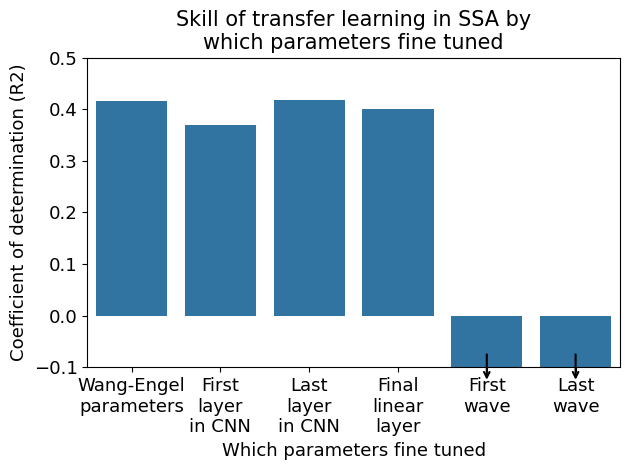

In [15]:
font_size = 13
fig, ax = plt.subplots()
sns.barplot(error_df_TL, x='transfer_method', y='R2', ax=ax)
ax.set_ylim((-0.1, 0.5))
ax.set_xlabel('Which parameters fine tuned', fontsize = font_size)
ax.set_ylabel('Coefficient of determination (R2)', fontsize = font_size)
ax.tick_params(which='both', labelsize = font_size)
ax.set_xticks(range(6), ['Wang-Engel\nparameters', 'First\nlayer\nin CNN','Last\nlayer\nin CNN', 'Final\nlinear\nlayer', 'First\nwave', 'Last\nwave'])
ax.set_title('Skill of transfer learning in SSA by\nwhich parameters fine tuned', fontsize = font_size + 2)
ax.annotate('', xy=(4, -0.07), xycoords='data',
            xytext=(4, -0.13), 
            arrowprops=dict(arrowstyle="<-", linewidth=1.5))
ax.annotate('', xy=(5, -0.07), xycoords='data',
            xytext=(5, -0.13),
            arrowprops=dict(arrowstyle="<-", linewidth=1.5))
fig.tight_layout()

In [2]:
err_df = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\error_df.csv').drop(columns=['Unnamed: 0'])

In [ ]:
err_df_useful = err_df.loc[((err_df['model'] == 'GDD Wang Engel')|(err_df['model'] == 'Logistic regression')|(err_df['model'] == 'random forests DTF'))&((err_df['evaluation method'] == '5-Fold')|(err_df['evaluation method'] == '5-fold'))]

In [6]:
err_df_useful.loc[6, 'model'] = 'Random Forests'
err_df_useful.loc[12, 'model'] = 'Random Forests'

In [7]:
err_df_useful

,model,region,evaluation method,R2,Bias (obs minus modelled),Variance,RMSE,STD,Corr,Min,LQ,Median,UQ,Max
0,GDD Wang Engel,Germany,5-Fold,0.422360,0.196544,57.469759,8.177595,7.580095,0.652758,-45.4,-4.60,0.0,5.00,39.0
1,GDD Wang Engel,SSA,5-Fold,0.242415,-0.133237,78.927194,10.486990,8.549305,0.549946,-21.4,-5.40,-0.2,4.75,37.4
3,Logistic regression,Germany,5-fold,0.446303,0.100999,50.377059,8.015746,7.096942,0.668896,-42.6,-5.00,-0.8,4.00,38.4
4,Logistic regression,SSA,5-fold,0.405319,0.918828,71.359880,9.228532,8.407529,0.666128,-17.0,-5.85,-1.2,4.60,32.8
6,Random Forests,SSA,5-fold,0.354385,0.894169,83.229527,9.438324,9.048926,0.643454,-17.2,-4.95,-1.0,4.15,36.0
12,Random Forests,Germany,5-fold,0.424623,0.032592,57.513525,8.198893,7.582813,0.653708,-52.8,-5.00,-0.4,4.20,48.8


Text(0.5, 1.0, 'Baseline model performance comparison\n(trained/evaluated in-domain)')

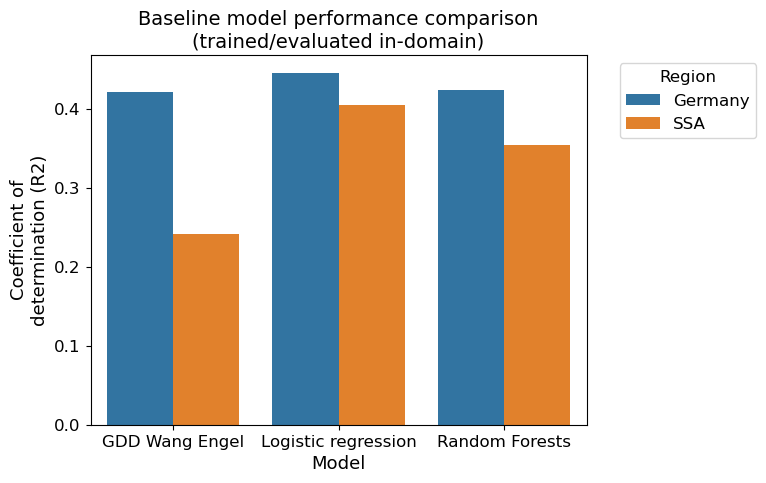

In [17]:
fig, ax = plt.subplots()
font_size = 12
sns.barplot(data=err_df_useful, x='model', y='R2', hue='region')
ax.tick_params(axis='both', which='major', labelsize=font_size)
ax.set_ylabel('Coefficient of\ndetermination (R2)', fontsize = font_size + 1)
ax.legend(title='Region', fontsize=font_size, title_fontsize=font_size, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('Model', fontsize = font_size + 1)
ax.set_title('Baseline model performance comparison\n(trained/evaluated in-domain)', fontsize = font_size + 2)

In [2]:
err_df = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\error_df.csv').drop(columns=['Unnamed: 0'])
err_df_useful = err_df.loc[(err_df['region'] == 'Germany')|(err_df['region'] == 'DE')|(err_df['evaluation method'] == 'Transfer DE to SSA')|(err_df['evaluation method'] == 'KG Transfer DE to SSA')]
R2s = [0.3179613947868347,0.22253692150115967,0.3240765929222107,0.16850709915161133,0.3345268964767456]
np.array(R2s).mean()
new_row = pd.DataFrame({"model": ["accumulated NN response"], "region": ["SSA"], 'evaluation method': ['fine tuning'], 'R2': np.array(R2s).mean(),
                        "Bias (obs minus modelled)": np.nan, "Variance": np.nan, "RMSE": np.nan, "STD": np.nan, "Corr": np.nan, "Min": np.nan, "LQ": np.nan, "Median": np.nan, "UQ": np.nan, "Max": np.nan})
err_df_useful = pd.concat([err_df_useful, new_row], axis=0)
err_df_useful.loc[15, 'evaluation method'] = 'fine tuning'
err_df_useful.iloc[0, 2] = '5-fold'
err_df_useful.loc[9, 'model'] = 'linear regression DTF'
err_df_useful.loc[3, 'model'] = 'logistic regression'
err_df_useful = err_df_useful.drop(21)
err_df_useful.loc[:, 'evaluation method'] = err_df_useful.loc[:, 'evaluation method'].str.replace('5-fold', 'Trained in DE,\nevaluated in DE')
err_df_useful.loc[:, 'evaluation method'] = err_df_useful.loc[:, 'evaluation method'].str.replace('Transfer DE to SSA', 'Trained in DE,\nevaluated in SSA')
err_df_useful.loc[:, 'evaluation method'] = err_df_useful.loc[:, 'evaluation method'].str.replace('fine tuning', 'Trained in DE,\nevaluated in SSA')
err_df_useful = err_df_useful.loc[err_df_useful['model'] != 'linear regression DTF']
err_df_useful = err_df_useful.rename(columns = {'evaluation method': 'Evaluation'})
err_df_useful.loc[:, 'model'] = err_df_useful.loc[:, 'model'].str.replace('GDD Wang Engel', 'GDD')
err_df_useful.loc[:, 'model'] = err_df_useful.loc[:, 'model'].str.replace('random forests DTF', 'Random\nforests')
err_df_useful.loc[:, 'model'] = err_df_useful.loc[:, 'model'].str.replace('logistic regression', 'logistic\nregression')
err_df_useful.loc[:, 'model'] = err_df_useful.loc[:, 'model'].str.replace('accumulated NN response', 'accumulated\nNN response')

Text(3.125, -0.23, '')

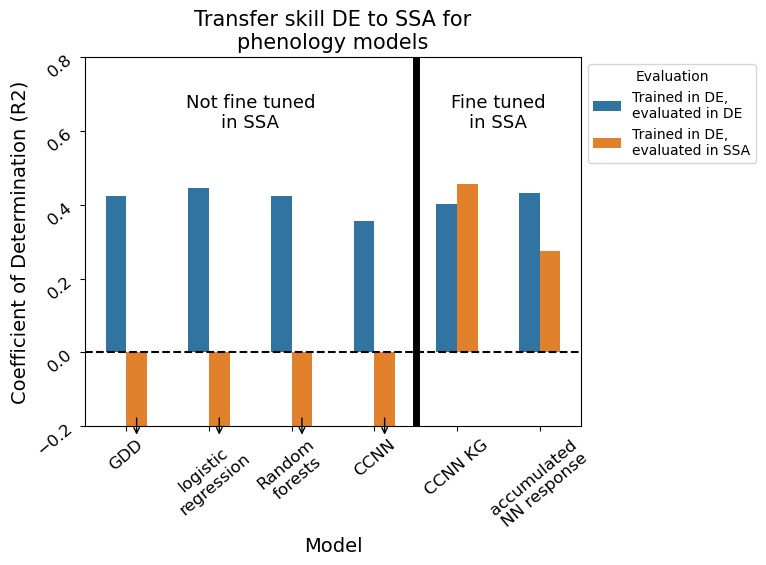

In [3]:
#fig, ax = plt.subplots()
font_size = 13
ax = sns.barplot(data = err_df_useful, x='model', y = 'R2', hue='Evaluation', width=0.5)
ax.set_ylim((-0.2, 0.8))
ax.axhline(0, color='k', linestyle = '--')
ax.axvline(3.5, color='k', linewidth = 5)
ax.tick_params(labelrotation=40, labelsize = font_size - 1)
ax.annotate('Not fine tuned\nin SSA',
            xy=(1.5, 0.65), xycoords='data',
            xytext=(0, 0), textcoords='offset pixels',
            horizontalalignment='center',
            verticalalignment='center', fontsize = font_size)
ax.annotate('Fine tuned\nin SSA',
            xy=(4.5, 0.65), xycoords='data',
            xytext=(0, 0), textcoords='offset pixels',
            horizontalalignment='center',
            verticalalignment='center', fontsize = font_size)
ax.set_xlabel('Model', fontsize = font_size + 1)
ax.set_ylabel('Coefficient of Determination (R2)', fontsize = font_size + 1)
sns.move_legend(ax, "upper left", bbox_to_anchor = (1, 1))
ax.set_title('Transfer skill DE to SSA for\nphenology models', fontsize = font_size + 2)
ax.annotate('', xy=(0.125, -0.17), xycoords='data',
            xytext=(0.125, -0.23),
            arrowprops=dict(arrowstyle="<-"))
ax.annotate('', xy=(1.125, -0.17), xycoords='data',
            xytext=(1.125, -0.23),
            arrowprops=dict(arrowstyle="<-"))
ax.annotate('', xy=(2.125, -0.17), xycoords='data',
            xytext=(2.125, -0.23),
            arrowprops=dict(arrowstyle="<-"))
ax.annotate('', xy=(3.125, -0.17), xycoords='data',
            xytext=(3.125, -0.23),
            arrowprops=dict(arrowstyle="<-"))

In [4]:
cf_both = pd.read_csv("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\compare_CCNN_model2.csv")
cf_both = cf_both.drop(columns=['Unnamed: 0'])
#ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5.csv')
ds_inputs_DE1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024_full.csv')
ds_inputs_DE1[[f't2max at day {n}' for n in range(180)]] += -273.15
ds_inputs_DE1[[f't2min at day {n}' for n in range(180)]] += -273.15
ds_inputs_DE2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_90s.csv')
ds_inputs_DE = pd.concat([ds_inputs_DE1, ds_inputs_DE2], axis = 0)
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE=ds_inputs_DE.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.dropna(how='all')
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] < 140]
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 40]
for vble in ['photoperiod', 'DTF', 'dev stage', 'vpd', 'ssrd', 't2max', 't2min', 'tp']:
    ds_inputs_DE = ds_inputs_DE.drop(columns = [col for col in ds_inputs_DE.columns if vble in col])
ds_inputs_DE_reduced = ds_inputs_DE.sample(frac = 0.2, random_state=1)

27153
27153


In [10]:
cf_both

,Stations_id,year,fitted,observed,Error,lat,lon,modelled time to beginning of flowering,discrepancy,Planting date
0,7521.0,2022.0,90.0,88.0,-1.678867,54.4333,9.8167,92.0,-2.0,2022-04-25
1,7521.0,2023.0,96.0,100.0,4.321133,54.4333,9.8167,93.0,3.0,2023-04-20
2,7521.0,2024.0,85.0,101.0,16.321133,54.4333,9.8167,86.0,-1.0,2024-04-28
3,7592.0,2023.0,78.0,84.0,6.321133,53.4833,10.6333,77.0,1.0,2023-05-10
4,7608.0,2024.0,79.0,73.0,-5.678867,53.5000,10.4833,79.0,0.0,2024-05-07
...,...,...,...,...,...,...,...,...,...,...
1443,19722.0,2023.0,76.0,68.0,-7.678867,47.8655,9.0147,75.0,1.0,2023-05-08
1444,19722.0,2024.0,80.0,84.0,4.321133,47.8655,9.0147,83.0,-3.0,2024-04-30
1445,19914.0,2022.0,79.0,67.0,-11.678867,50.3168,9.3627,75.0,4.0,2022-05-06
1446,19914.0,2023.0,75.0,66.0,-8.678867,50.3168,9.3627,71.0,4.0,2023-05-19


In [5]:
ds_inputs_DE['Planting date']

0        2004-05-03
1        2005-04-25
2        2007-04-20
3        2008-04-28
4        2009-05-04
            ...    
10900    1991-04-23
10901    1993-04-24
10902    1994-04-30
10903    1998-05-08
10904    1999-04-30
Name: Planting date, Length: 27143, dtype: object

In [17]:
cf_both = pd.read_csv("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\compare_CCNN_model.csv")#without 2 for old result
cf_both = cf_both.drop(columns=['Unnamed: 0'])
cf_both = cf_both.merge(ds_inputs_DE[['Stations_id', 'year', 'Planting date']], on=['Stations_id', 'year'], how='left')
for column in ['observed', 'fitted', 'modelled time to beginning of flowering']:
    cf_both.loc[:, column] = pd.to_datetime(cf_both['Planting date']).dt.dayofyear + cf_both.loc[:, column]

In [20]:
cf_both['fitted'] = cf_both['fitted'] - cf_both['fitted'].mean() + cf_both['modelled time to beginning of flowering'].mean()

In [21]:
cf_both

,Stations_id,year,fitted,observed,Error,lat,lon,modelled time to beginning of flowering,discrepancy,Planting date
0,7521.0,2022.0,202.47721,203.0,-1.678867,54.4333,9.8167,207.0,-2.0,2022-04-25
1,7521.0,2023.0,203.47721,210.0,4.321133,54.4333,9.8167,203.0,3.0,2023-04-20
2,7521.0,2024.0,201.47721,220.0,16.321133,54.4333,9.8167,205.0,-1.0,2024-04-28
3,7592.0,2023.0,205.47721,214.0,6.321133,53.4833,10.6333,207.0,1.0,2023-05-10
4,7608.0,2024.0,204.47721,201.0,-5.678867,53.5000,10.4833,207.0,0.0,2024-05-07
...,...,...,...,...,...,...,...,...,...,...
1443,19722.0,2023.0,201.47721,196.0,-7.678867,47.8655,9.0147,203.0,1.0,2023-05-08
1444,19722.0,2024.0,198.47721,205.0,4.321133,47.8655,9.0147,204.0,-3.0,2024-04-30
1445,19914.0,2022.0,202.47721,193.0,-11.678867,50.3168,9.3627,201.0,4.0,2022-05-06
1446,19914.0,2023.0,211.47721,205.0,-8.678867,50.3168,9.3627,210.0,4.0,2023-05-19


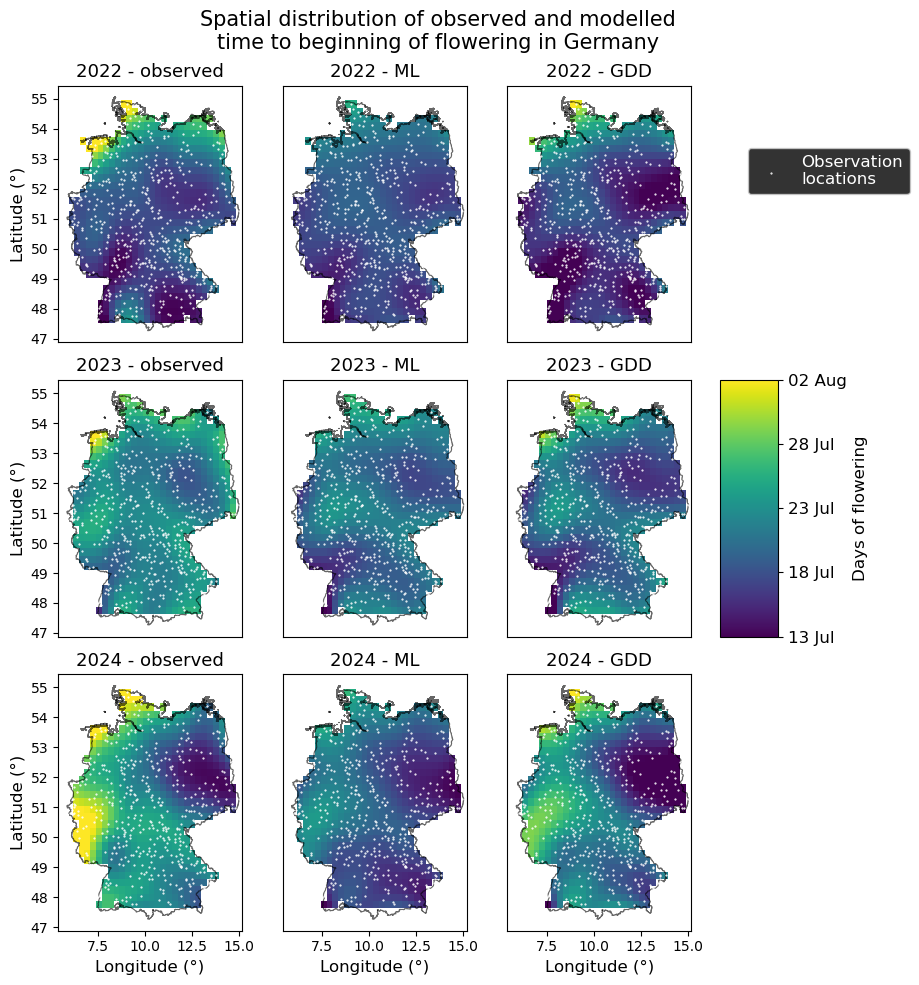

In [22]:
import copy
n_cells = 30 #number of cells to evaluate smooth
bandwidth = 0.7 #bandwidth for kernel smooth in degrees. 0.7 seems to work best
figsize = 10
label_size = 13
DE_adm = gpd.read_file('gadm41_DEU_1/gadm41_DEU_1.shp').dissolve()
#fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig = plt.figure()
fig.set_figheight(figsize)#15
fig.set_figwidth(figsize*(10/9)*(4/5))#22
axs = []
axs.append(plt.subplot2grid(shape=(9, 10), loc=(0, 0), colspan=3, rowspan = 3))
axs.append(plt.subplot2grid(shape=(9, 10), loc=(3, 0), colspan=3, rowspan = 3))
axs.append(plt.subplot2grid(shape=(9, 10), loc=(6, 0), colspan=3, rowspan = 3))
axs.append(plt.subplot2grid(shape=(9, 10), loc=(0, 3), colspan=3, rowspan = 3))
axs.append(plt.subplot2grid(shape=(9, 10), loc=(3, 3), colspan=3, rowspan = 3))
axs.append(plt.subplot2grid(shape=(9, 10), loc=(6, 3), colspan=3, rowspan = 3))
axs.append(plt.subplot2grid(shape=(9, 10), loc=(0, 6), colspan=3, rowspan = 3))
axs.append(plt.subplot2grid(shape=(9, 10), loc=(3, 6), colspan=3, rowspan = 3))
axs.append(plt.subplot2grid(shape=(9, 10), loc=(6, 6), colspan=3, rowspan = 3))
#axs.append(plt.subplot2grid(shape=(9, 10), loc=(0, 9), colspan=1, rowspan = 3))
axs.append(plt.subplot2grid(shape=(9, 10), loc=(3, 9), colspan=1, rowspan = 3))
#axs.append(plt.subplot2grid(shape=(9, 10), loc=(6, 9), colspan=1, rowspan = 3))
for i_year, year in enumerate([2022, 2023, 2024]):
    cf_both_year = cf_both.loc[cf_both['year'] == year]
    x = cf_both_year['lon'].values
    y = cf_both_year['lat'].values
    z = cf_both_year['observed'].values
    # make regular grid
    xi = np.linspace(x.min(), x.max(), n_cells)
    yi = np.linspace(y.min(), y.max(), n_cells)
    xi, yi = np.meshgrid(xi, yi)
    xy = gpd.GeoDataFrame({'geometry': gpd.points_from_xy(xi.flatten(), yi.flatten()), 'ref_index': np.array(range(len(yi.flatten())))}, crs='EPSG:4326')
    intersection = gpd.overlay(DE_adm, xy, keep_geom_type=False)
    # Kernel regression on irregular 2D data
    vmax = cf_both_year['observed'].quantile(0.9)
    vmin = cf_both_year['observed'].quantile(0.1)
    for i_model, obs_or_model in enumerate(['observed', 'fitted', 'modelled time to beginning of flowering']):
        title = ['observed', 'ML', 'GDD'][i_model]
        axis_index = (i_model * 3) + i_year
        ax = axs[axis_index]
        #cf_both_year.loc[:, obs_or_model] = cf_both_year[obs_or_model] - cf_both_year[obs_or_model].mean()
        kr = KernelReg(endog=cf_both_year[obs_or_model].values, exog=[cf_both_year['lon'].values, cf_both_year['lat'].values], var_type='cc', bw=[bandwidth, bandwidth])
        z_smooth, _ = kr.fit([xi.flatten(),yi.flatten()])
        compliment = np.delete(np.arange(n_cells**2), intersection['ref_index'].values)
        z_smooth[compliment] = np.nan
        #z_smooth = z_smooth - z_smooth.mean()
        z_smooth = z_smooth.reshape((n_cells, n_cells))
        img = ax.pcolormesh(xi, yi, z_smooth, vmin=195, vmax = 215)# vmin=vmin - 5, vmax = vmax + 5)#vmin = 75, vmax = 90, zorder = 0)# -7, 7 when detrending75, 90
        #geoplot.polyplot(DE_adm.explode(), ax=ax, zorder=1, alpha = 0.6)
        DE_adm.explode().boundary.plot(ax=ax, zorder=1, color='black', linewidth = 0.8, alpha = 0.6)
        if (title == 'observed') & (year == 2023):
            cbar = fig.colorbar(img, cax = axs[9])#+ i_year
            cbar.set_label('Days of flowering', fontsize = label_size - 1) #'Estimated change in\npercentage error'
            cbar.ax.tick_params(labelsize=label_size - 1)
            cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: (pd.to_datetime(f'2000-01-01') + pd.to_timedelta(x - 1, unit='D')).strftime('%d %b')))
            ax.scatter(x, y, c='white', s=0.2*(figsize/7), zorder=2, label = 'Observation\nlocations')
        else:
            ax.scatter(x, y, c='white', zorder=2, s=0.2*(figsize/7))
        if axis_index in [5, 8]:
            ax.set_xlabel('Longitude (°)', fontsize = label_size-1)
            ax.tick_params(left = False, labelleft = False)
        elif axis_index in [0, 1]:
            ax.set_ylabel('Latitude (°)', fontsize = label_size-1)
            ax.tick_params(bottom = False, labelbottom = False)
        elif axis_index == 2:
            ax.set_xlabel('Longitude (°)', fontsize = label_size-1)
            ax.set_ylabel('Latitude (°)', fontsize = label_size-1)
        else:
            ax.tick_params(left = False, labelleft = False, bottom = False, labelbottom = False)
        ax.set_title(f'{year} - {title}', fontsize = label_size)
fig.suptitle('Spatial distribution of observed and modelled\ntime to beginning of flowering in Germany', fontsize = label_size + 2)
fig.legend(bbox_to_anchor=(1.04, 0.85), facecolor='black', labelcolor='white', fontsize = label_size - 1)
fig.tight_layout()

In [24]:
year_means = ds_inputs_DE[['year', 'observed time to beginning of flowering']].groupby('year').mean()

In [13]:
cf_both_year

,Stations_id,year,fitted,observed,Error,lat,lon,modelled time to beginning of flowering,discrepancy,Planting date
2,7521.0,2024.0,85.0,101.0,16.321133,54.4333,9.8167,86.0,-1.0,2024-04-28
4,7608.0,2024.0,79.0,73.0,-5.678867,53.5000,10.4833,79.0,0.0,2024-05-07
7,7623.0,2024.0,76.0,76.0,0.321133,54.6667,9.1333,83.0,-7.0,2024-05-15
11,7650.0,2024.0,79.0,75.0,-3.678867,54.1000,10.8167,81.0,-2.0,2024-05-09
14,7662.0,2024.0,77.0,76.0,-0.678867,53.7333,9.7833,79.0,-2.0,2024-05-12
...,...,...,...,...,...,...,...,...,...,...
1438,19612.0,2024.0,77.0,78.0,1.321133,52.0507,10.6362,76.0,1.0,2024-05-09
1439,19650.0,2024.0,78.0,96.0,18.321133,51.0716,8.2904,87.0,-9.0,2024-05-18
1441,19700.0,2024.0,83.0,88.0,5.321133,50.4316,11.9443,84.0,-1.0,2024-05-01
1444,19722.0,2024.0,80.0,84.0,4.321133,47.8655,9.0147,83.0,-3.0,2024-04-30


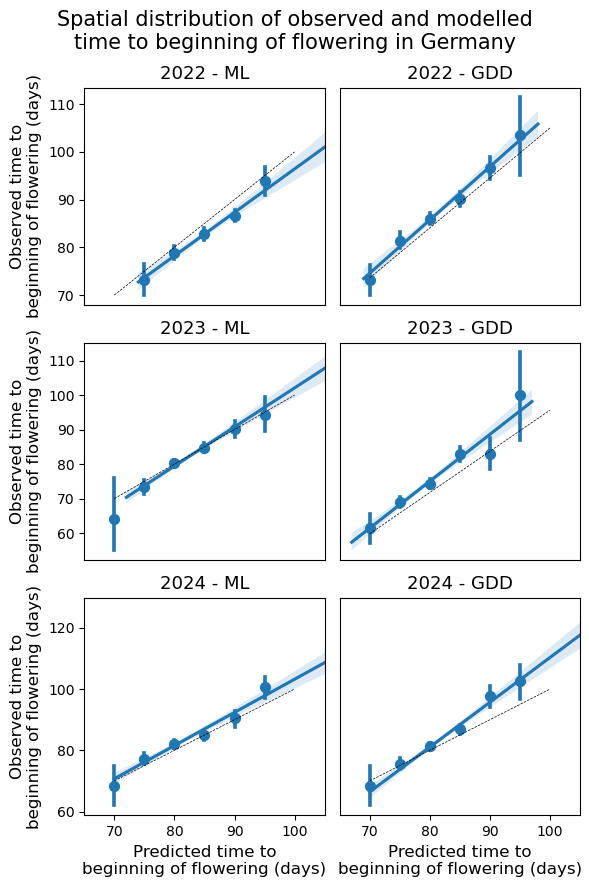

In [15]:
label_size = 13
fig, axs = plt.subplots(3, 2, figsize=(6, 9))
for i_year, year in enumerate([2022, 2023, 2024]):
    cf_both_year = cf_both.loc[cf_both['year'] == year]
    for i_model, model in enumerate(['fitted', 'modelled time to beginning of flowering']):
        title = ['ML', 'GDD'][i_model]
        ax = axs[i_year, i_model]
        sns.regplot(data=cf_both_year, x=model, y='observed', x_bins = np.arange(70, 100, 5), ax=ax)
        ax.set_xlim((65, 105))
        ax.plot([70, 100], [70, 100], color='black', linestyle = '--', linewidth = 0.5)
        ax.set_title(f'{year} - {title}', fontsize = label_size)
        if i_model == 0 and i_year in [0, 1]:
            ax.set_ylabel('Observed time to\nbeginning of flowering (days)', fontsize = label_size - 1)
            ax.tick_params(bottom = False, labelbottom = False)
            ax.set_xlabel('')
        elif i_model == 0 and i_year == 2:
            ax.set_ylabel('Observed time to\nbeginning of flowering (days)', fontsize = label_size - 1)
            ax.set_xlabel('Predicted time to\nbeginning of flowering (days)', fontsize = label_size - 1)
        elif i_model == 1 and i_year == 2:
            ax.set_xlabel('Predicted time to\nbeginning of flowering (days)', fontsize = label_size - 1)
            ax.tick_params(left = False, labelleft = False)
            ax.set_ylabel('')
        else:
            ax.tick_params(left = False, labelleft = False, bottom = False, labelbottom = False)
            ax.set_xlabel('')
            ax.set_ylabel('')
        
fig.suptitle('Spatial distribution of observed and modelled\ntime to beginning of flowering in Germany', fontsize = label_size + 2)
#fig.legend(bbox_to_anchor=(1.06, 0.85), facecolor='black', labelcolor='white', fontsize = label_size - 1)
fig.tight_layout()

In [ ]:

    cf_both_year = cf_both.loc[cf_both['year'] == 2024]
    # Kernel regression on irregular 2D data
    kr = KernelReg(endog=cf_both_year['observed'].values, exog=[cf_both_year['lon'].values, cf_both_year['lat'].values], var_type='cc', bw=[0.5, 0.5])
    z_smooth, _ = kr.fit([xi.flatten(),yi.flatten()])
    z_smooth = z_smooth.reshape((50, 50))

    #img = plt.imshow(z_smooth)
    fig, ax = plotting.Germany_plot()
    z_smooth2 = z_smooth#[z_smooth > 80]
    img = ax.pcolormesh(xi, yi, z_smooth2, vmin=80, vmax = 100)

    plt.colorbar(img)
    ax.scatter(x, y, c='white', s=0.5)
    #plt.colorbar(img)

In [ ]:
cf_both['']

In [58]:
zi[10:30, 10:30].max()

np.float64(106.48375832229604)

In [38]:
zi_smooth

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [3]:
error_df = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\error_df.csv')
error_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
error_SSA = error_df.loc[error_df['region'] == 'SSA']
error_SSA= error_SSA.loc[error_SSA['evaluation method'] == '5-fold']

In [11]:
error_SSA = error_SSA.reset_index()#.loc[1, :]

In [16]:
p = np.array([1, -2*error_SSA.loc[0, 'STD']*error_SSA.loc[0, 'Corr'], error_SSA.loc[0, 'STD']**2 - error_SSA.loc[0, 'RMSE']**2])

In [20]:
for row in range(4):
    p = np.array([1, -2*error_SSA.loc[row, 'STD']*error_SSA.loc[row, 'Corr'], error_SSA.loc[row, 'STD']**2 - error_SSA.loc[row, 'RMSE']**2])
    print(np.roots(p)[0])

12.371372218427567
12.677220945553804
12.233586386823992
13.6937982985195


In [ ]:
np.roots(p)[0]

array([12.37137222, -1.17038381])

In [4]:
def taylor_stats_existing(ccoef, crmsd, sdev):
    crmsd_for_diag = [0, crmsd]
    p = np.array([1, -2*sdev*ccoef, sdev**2 - crmsd**2])
    sdev_obs = np.roots(p)[0]
    sdev_for_diag = [sdev_obs, sdev]
    ccoef_for_diag = [1, ccoef]
    return {'ccoef': ccoef_for_diag, 'crmsd': crmsd_for_diag, 'sdev': sdev_for_diag}

In [73]:
marker_size = 9
in_domain_symbol = '+'
transfer_symbol = '.'
MARKERS = {
        "GDD in domain": {
            "labelColor": "k",
            "symbol": in_domain_symbol,
            "size": marker_size,
            "faceColor": "w",
            "edgeColor": "r",
        },
        "GDD transfer": {
            "labelColor": "k",
            "symbol": transfer_symbol,
            "size": marker_size,
            "faceColor": "w",
            "edgeColor": "r",
        },
        "regression in domain": {
            "labelColor": "k",
            "symbol": in_domain_symbol,
            "size": marker_size,
            "faceColor": "g",
            "edgeColor": "g",
        },
        "regression transfer": {
            "labelColor": "k",
            "symbol": transfer_symbol,
            "size": marker_size,
            "faceColor": "g",
            "edgeColor": "g",
        },
        "RF in domain": {
            "labelColor": "k",
            "symbol": in_domain_symbol,
            "size": marker_size,
            "faceColor": "m",
            "edgeColor": "m",
        },
        "RF transfer": {
            "labelColor": "k",
            "symbol": transfer_symbol,
            "size": marker_size,
            "faceColor": "m",
            "edgeColor": "m",
        },
        "CCNN KG in domain": {
            "labelColor": "k",
            "symbol": in_domain_symbol,
            "size": marker_size,
            "faceColor": "c",
            "edgeColor": "c",
        },
        "CCNN FT": {
            "labelColor": "k",
            "symbol": transfer_symbol,
            "size": marker_size,
            "faceColor": "c",
            "edgeColor": "c",
        },
        "CCNN in domain": {
            "labelColor": "k",
            "symbol": in_domain_symbol,
            "size": marker_size,
            "faceColor": "k",
            "edgeColor": "k",
        },
        "CCNN transfer": {
            "labelColor": "k",
            "symbol": transfer_symbol,
            "size": marker_size,
            "faceColor": "k",
            "edgeColor": "k",
        },
        "Accumulated NN in domain": {
            "labelColor": "k",
            "symbol": in_domain_symbol,
            "size": marker_size,
            "faceColor": "b",
            "edgeColor": "b",
        },
        "Accumulated NN transfer": {
            "labelColor": "k",
            "symbol": transfer_symbol,
            "size": marker_size,
            "faceColor": "b",
            "edgeColor": "b",
            "alpha": 0,
        },
        
    }

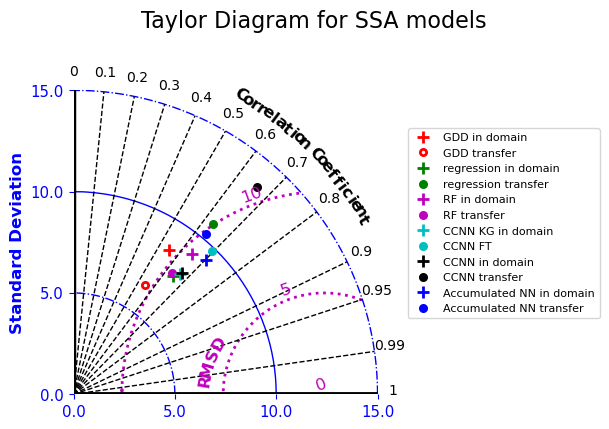

In [97]:
T_stats_list = []
SSA_comp_rows = [1, 2, 5, 9, 6, 10, 16, 15, 14, 13, 20, 21]#
#SSA_comp_rows = [0, 11, 12, 17, 18, 19]
#SSA_comp_rows = [16, 15, 20, 21]
for row in SSA_comp_rows:
    T_stats = taylor_stats_existing(error_df.loc[row, 'Corr'], error_df.loc[row, 'RMSE'], error_df.loc[row, 'STD'])
    T_stats_list.append(T_stats)

# Store statistics in arrays
sdev = np.array([T_stats_list[0]['sdev'][0]] + [T_stats_list[n]['sdev'][1] for n in range(len(SSA_comp_rows))])
crmsd = np.array([T_stats_list[0]['crmsd'][0]] + [T_stats_list[n]['crmsd'][1] for n in range(len(SSA_comp_rows))])
ccoef = np.array([T_stats_list[0]['ccoef'][0]] + [T_stats_list[n]['ccoef'][1] for n in range(len(SSA_comp_rows))])

# Specify labels for points in a cell array (M1 for model prediction 1,
# etc.). Note that a label needs to be specified for the reference even
# though it is not used.
label = ['Non-Dimensional Observation'] + [error_df.loc[n, 'model'] + '\n' + error_df.loc[n, 'evaluation method'] for n in SSA_comp_rows]


#sm.taylor_diagram(sdev,crmsd,ccoef, markers = MARKERS, 
#                      markerLegend = 'on', styleOBS = '-', colOBS = 'r', markerobs = 'o',
#                      tickRMS = [0.0, 1.0, 2.0, 3.0],
#                      tickRMSangle = 115, showlabelsRMS = 'on',
#                      titleRMS = 'on', titleOBS = 'Ref')
fig, ax = plt.subplots()#figsize=(8, 8))
sm.taylor_diagram(ax, sdev,crmsd,ccoef, #markerLabel = label,
                      markers = MARKERS, markerLegend = 'on',# markerLabelColor = 'r', markercolor = ['r' for count in range(len(SSA_comp_rows))],
                      tickRMS = range(0,15,5), tickRMSangle = 110.0,
                      colRMS = 'm', styleRMS = ':', widthRMS = 2.0, 
                      titleRMS = 'on', tickSTD = range(0,15,5), 
                      axismax = 15, colSTD = 'b', styleSTD = '-.', 
                      widthSTD = 1.0, titleSTD = 'on', 
                      colCOR = 'k', styleCOR = '--', widthCOR = 1.0, 
                      titleCOR = 'on') #
fig.suptitle('Taylor Diagram for SSA models', fontsize=16)
fig.savefig('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\plots\\SSA_taylor_diag.png', bbox_inches='tight')

(-10.0, 10.0)

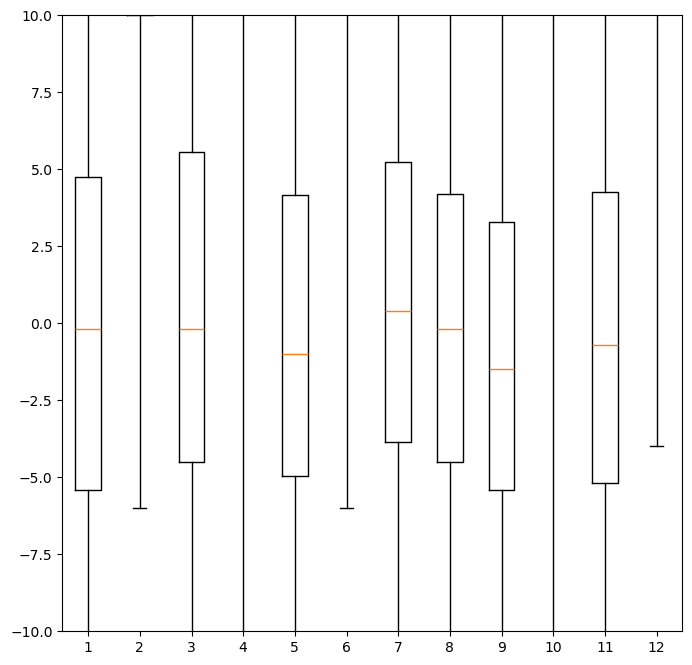

In [92]:
bxp_details = []
for row in SSA_comp_rows:
    bxp_details.append({'med': error_df.loc[row, 'Median'], 'q1': error_df.loc[row, 'LQ'], 'q3': error_df.loc[row, 'UQ'], 'whislo': error_df.loc[row, 'Min'], 'whishi': error_df.loc[row, 'Max']})
fig, ax = plt.subplots(figsize=(8, 8))
ax.bxp(bxp_details, showfliers=False)
ax.set_ylim(-10, 10)

<Axes: >

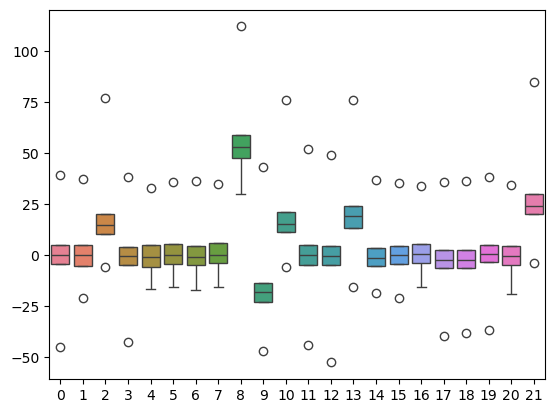

In [88]:
sns.boxplot(error_df[['Min', 'LQ', 'Median', 'UQ', 'Max']].T)#.loc[SSA_comp_rows].plot.box()

In [85]:
error_df

,model,region,evaluation method,R2,Bias (obs minus modelled),Variance,RMSE,STD,Corr,Min,LQ,Median,UQ,Max
0,GDD Wang Engel,Germany,5-Fold,0.422360,0.196544,57.469759,8.177595,7.580095,0.652758,-45.4,-4.60,0.0,5.00,39.0
1,GDD Wang Engel,SSA,5-Fold,0.242415,-0.133237,78.927194,10.486990,8.549305,0.549946,-21.4,-5.40,-0.2,4.75,37.4
2,GDD Wang Engel,SSA,Transfer DE to SSA,-1.299031,15.346491,41.795502,10.173415,6.464944,0.546211,-6.0,10.00,14.5,20.00,77.0
3,Logistic regression,Germany,5-fold,0.446303,0.100999,50.377059,8.015746,7.096942,0.668896,-42.6,-5.00,-0.8,4.00,38.4
4,Logistic regression,SSA,5-fold,0.405319,0.918828,71.359880,9.228532,8.407529,0.666128,-17.0,-5.85,-1.2,4.60,32.8
5,linear regression DTF,SSA,5-fold,0.373997,3.348015,58.993333,9.699900,7.630353,0.645322,-15.6,-4.50,-0.2,5.55,35.6
6,random forests DTF,SSA,5-fold,0.354385,0.894169,83.229527,9.438324,9.048926,0.643454,-17.2,-4.95,-1.0,4.15,36.0
7,random forests classification,SSA,5-fold,0.339676,5.194968,87.124543,10.378714,9.314278,0.652924,-16.0,-4.20,0.0,5.90,34.6
8,logistic regression,SSA,Transfer DE to SSA,-18.872547,53.838583,16.444322,10.806163,4.055160,0.514927,30.0,47.25,53.0,59.00,112.0
9,regression DTF,SSA,Transfer DE to SSA,-1.632538,-17.307087,117.775419,9.995678,10.852438,0.633848,-47.0,-23.00,-18.0,-14.00,43.0


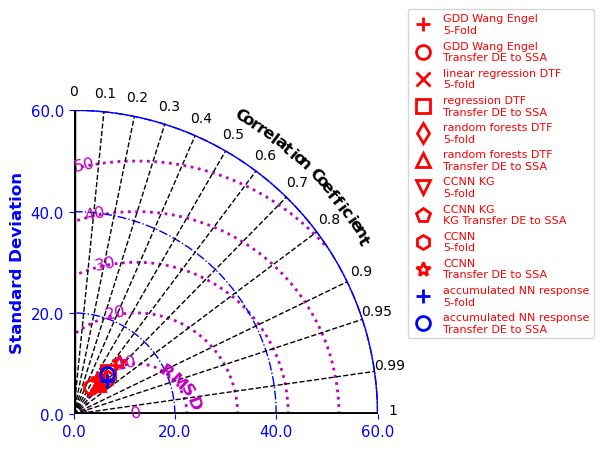

In [15]:
sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel = label,
                      markerLabelColor = 'r', markerLegend = 'on', 
                      tickRMS = range(0,60,10), 
                      colRMS = 'm', styleRMS = ':', widthRMS = 2.0, 
                      titleRMS = 'on', titleRMSDangle = 40.0, tickSTD = range(0,80,20),
                      axismax = 60.0, colSTD = 'b', styleSTD = '-.', 
                      widthSTD = 1.0, titleSTD = 'on', 
                      colCOR = 'k', styleCOR = '--', widthCOR = 1.0, 
                      titleCOR = 'on', markerSize = 10, alpha = 0.0)

In [30]:
error_df

,model,region,evaluation method,R2,Bias (obs minus modelled),Variance,RMSE,STD,Corr,Min,LQ,Median,UQ,Max
0,GDD Wang Engel,Germany,5-Fold,0.422360,0.196544,57.469759,8.177595,7.580095,0.652758,-45.4,-4.60,0.0,5.00,39.0
1,GDD Wang Engel,SSA,5-Fold,0.242415,-0.133237,78.927194,10.486990,8.549305,0.549946,-21.4,-5.40,-0.2,4.75,37.4
2,GDD Wang Engel,SSA,Transfer DE to SSA,-1.299031,15.346491,41.795502,10.173415,6.464944,0.546211,-6.0,10.00,14.5,20.00,77.0
3,Logistic regression,Germany,5-fold,0.446303,0.100999,50.377059,8.015746,7.096942,0.668896,-42.6,-5.00,-0.8,4.00,38.4
4,Logistic regression,SSA,5-fold,0.405319,0.918828,71.359880,9.228532,8.407529,0.666128,-17.0,-5.85,-1.2,4.60,32.8
5,linear regression DTF,SSA,5-fold,0.373997,3.348015,58.993333,9.699900,7.630353,0.645322,-15.6,-4.50,-0.2,5.55,35.6
6,random forests DTF,SSA,5-fold,0.354385,0.894169,83.229527,9.438324,9.048926,0.643454,-17.2,-4.95,-1.0,4.15,36.0
7,random forests classification,SSA,5-fold,0.339676,5.194968,87.124543,10.378714,9.314278,0.652924,-16.0,-4.20,0.0,5.90,34.6
8,logistic regression,SSA,Transfer DE to SSA,-18.872547,53.838583,16.444322,10.806163,4.055160,0.514927,30.0,47.25,53.0,59.00,112.0
9,regression DTF,SSA,Transfer DE to SSA,-1.632538,-17.307087,117.775419,9.995678,10.852438,0.633848,-47.0,-23.00,-18.0,-14.00,43.0


In [ ]:

# Calculate correlation coefficient
ccoef = ccoef[0]

# Calculate centered root-mean-square (RMS) difference (E')^2
crmsd = [0.0, centered_rms_dev(p,r)]

# Calculate standard deviation of predicted field w.r.t N (sigma_p)
sdevp = np.std(p)

# Calculate standard deviation of reference field w.r.t N (sigma_r)
sdevr = np.std(r)
sdev = [sdevr, sdevp];

# Store statistics in a dictionary
stats = {'ccoef': ccoef, 'crmsd': crmsd, 'sdev': sdev}